<div dir="rtl">

## گزارش کلی

در این بخش، هدف تحلیل تصاویر MRI مغز است و با مقایسه‌ی بین دو نیم‌کره‌ی مغز (چپ و راست)، نواحی دارای تفاوت قابل توجه شناسایی شده و به‌عنوان ضایعه مشخص می‌گردند.

---

####بارگذاری تصاویر

در بخش های کامنت شده با عناوین ``Read MRI images`` و ``Split into hemispheres``،  هشت تصویر MRI با فرمت `.jpeg` بارگذاری می‌شوند و برای هر تصویر، به دو نیم‌کره‌ی چپ و راست تقسیم می‌گردند.

---

#### تطبیق هیستوگرام بین دو نیم‌کره

برای مقایسه‌ی بهتر بین دو نیم‌کره، ابتدا هیستوگرام نیم‌کره‌ی چپ بر نیم‌کره‌ی راست تطبیق داده می‌شود (Histogram Matching).

از تابع ``match_histograms`` استفاده می‌شود

خروجی این مرحله تصویری است که از لحاظ شدت روشنایی با نیم‌کره‌ی چپ هم‌تراز شده است.

---

#### بررسی تفاوت‌ها و شناسایی ضایعه

پس از تطبیق هیستوگرام، تصویر تفاضلی محاسبه می‌شود:

``diff = np.abs(matched - right_halves[i])``

تفاوت بیش از یک آستانه‌ی مشخص (مثلاً 25) به‌عنوان ناحیه‌ی مشکوک به ضایعه در نظر گرفته می‌شود.


این نواحی توسط تابع ``detect_lesions`` شناسایی می‌شوند.

---

#### الگوریتم تشخیص ضایعه

برای شناسایی نواحی ضایعه، الگوریتم زیر اجرا می‌شود:
- تصویر تفاوتی ``diff`` با ``threshold`` مشخص دودویی  می‌شود.

- با استفاده از تابع ``label`` از کتابخانه‌ی ``skimage.measure``، نواحی متصل پیدا می‌شوند.

- با استفاده از ``regionprops`` مختصات هر ناحیه به‌دست می‌آید.

- این مختصات برای ترسیم مستطیل‌هایی دور نواحی مشکوک استفاده می‌شود.

- چون این ضایعات در نیم‌کره‌ی راست هستند، مختصات افقی (x) با نیم‌عرض تصویر جبران می‌شود.

---

####  نمایش خروجی‌ها

برای هر تصویر MRI، خروجی‌های زیر نمایش داده می‌شود:

- تصویر اصلی MRI
- هیستوگرام دو نیم‌کره (برای مقایسه شدت روشنایی)
- تصویر تفاوتی به‌صورت Heatmap
- تصویر MRI همراه با ترسیم محل‌های ضایعه به رنگ قرمز
- تصویر دودویی حاصل از آستانه‌گذاری تصویر تفاوتی

---

####توضیحات تکمیلی

باید اشاره کنم که برای این سوال، حالت های مختلفی را امتحان کردم تا به نتایج بهتری برسم، ولی به علت اینکه روند تشخیص ضایعه در این سوال ``histogram matching`` است، با توجه به اینکه تصویر مغز ممکن است کج باشد، همچنین در حالت سالم نیز دو نیمکره مغز را نمیتوان دقیقا متقارن در نظر گرفت، در نتایجم خطا مشاهده می شود؛ بطور مثال در برخی حالات، کادر دور مغز نیز بعنوان ضایعه تشخیص داده شده است.

در هر صورت با استفاده از الگوریتم های پیجیده تر، یقینا نتایج دقیق تری حاصل خواهد شد.این مورد را نیز در نظر بگیرید که در ``heatmap`` هایی که رسم شده است، ضایعه های احتمالی واضح تر دیده می شوند ولی در نهایت بعضی از آنها بعنوان ضایعه گزارش نشده اند.

لازم به ذکر است که من برای انجام این پروژه از ``chatgpt`` و ``deep seek`` کمک گرفتم.


</div>

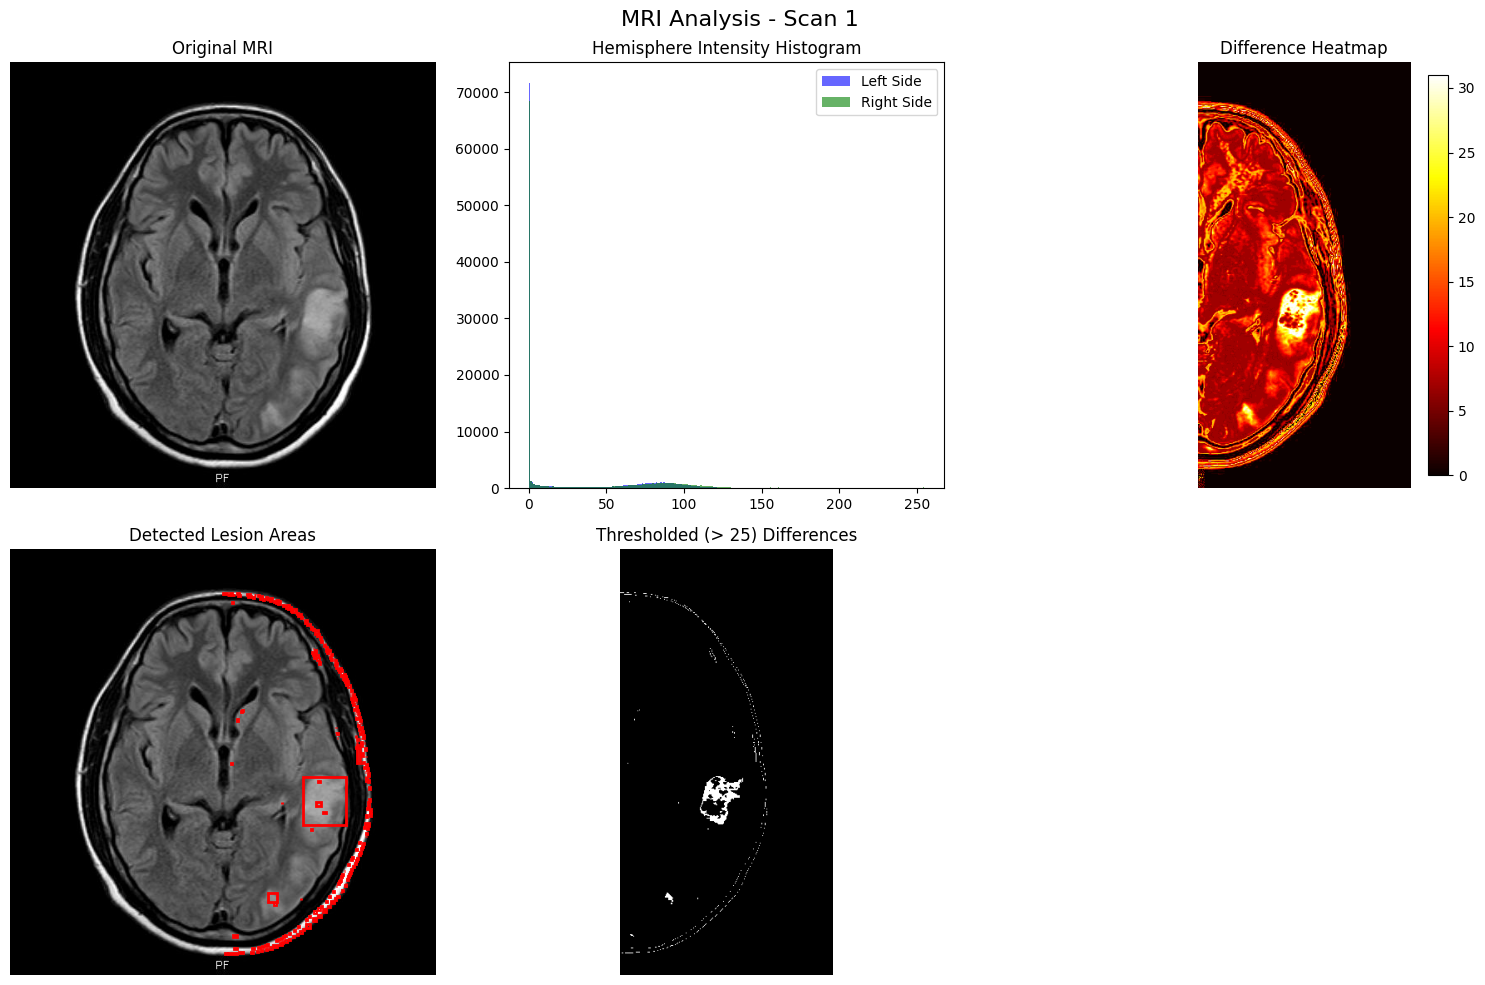

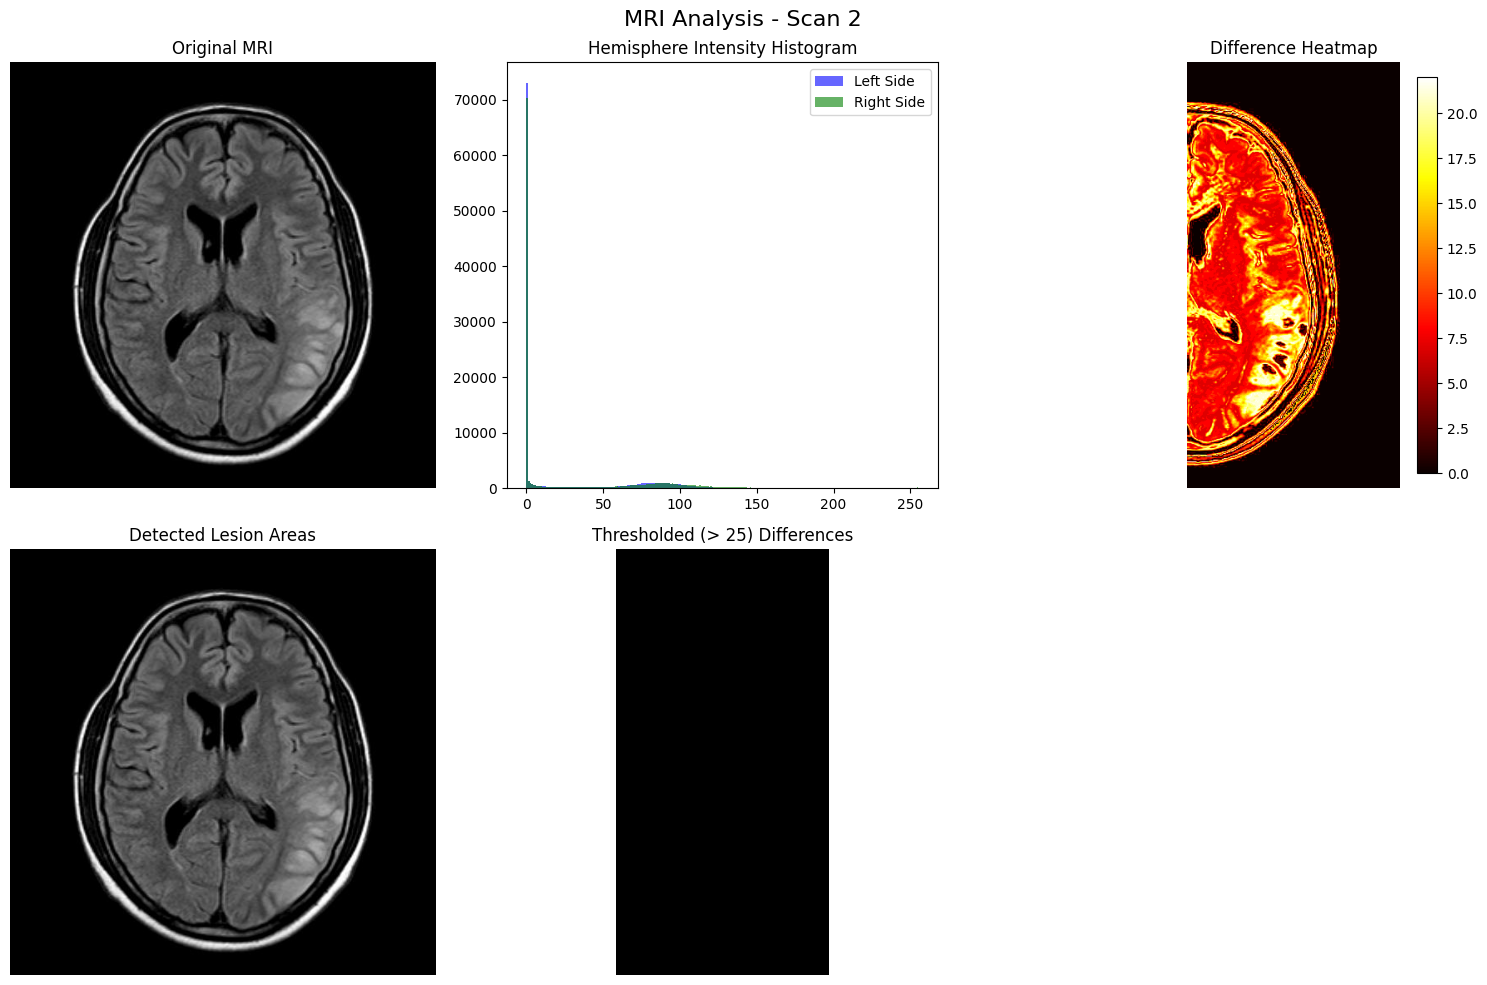

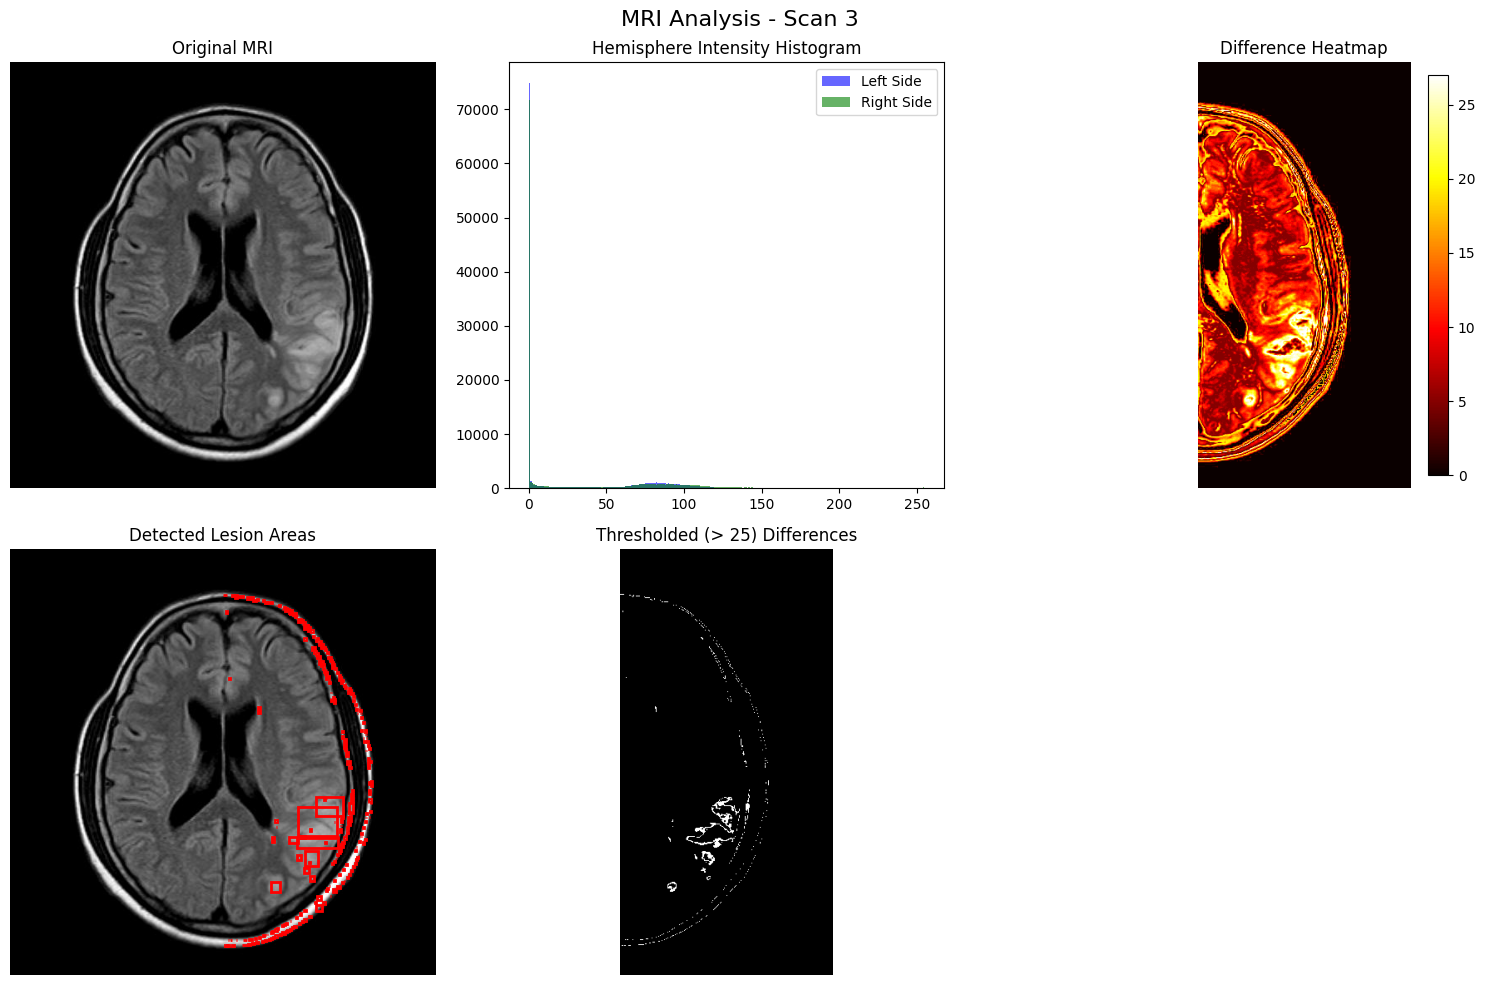

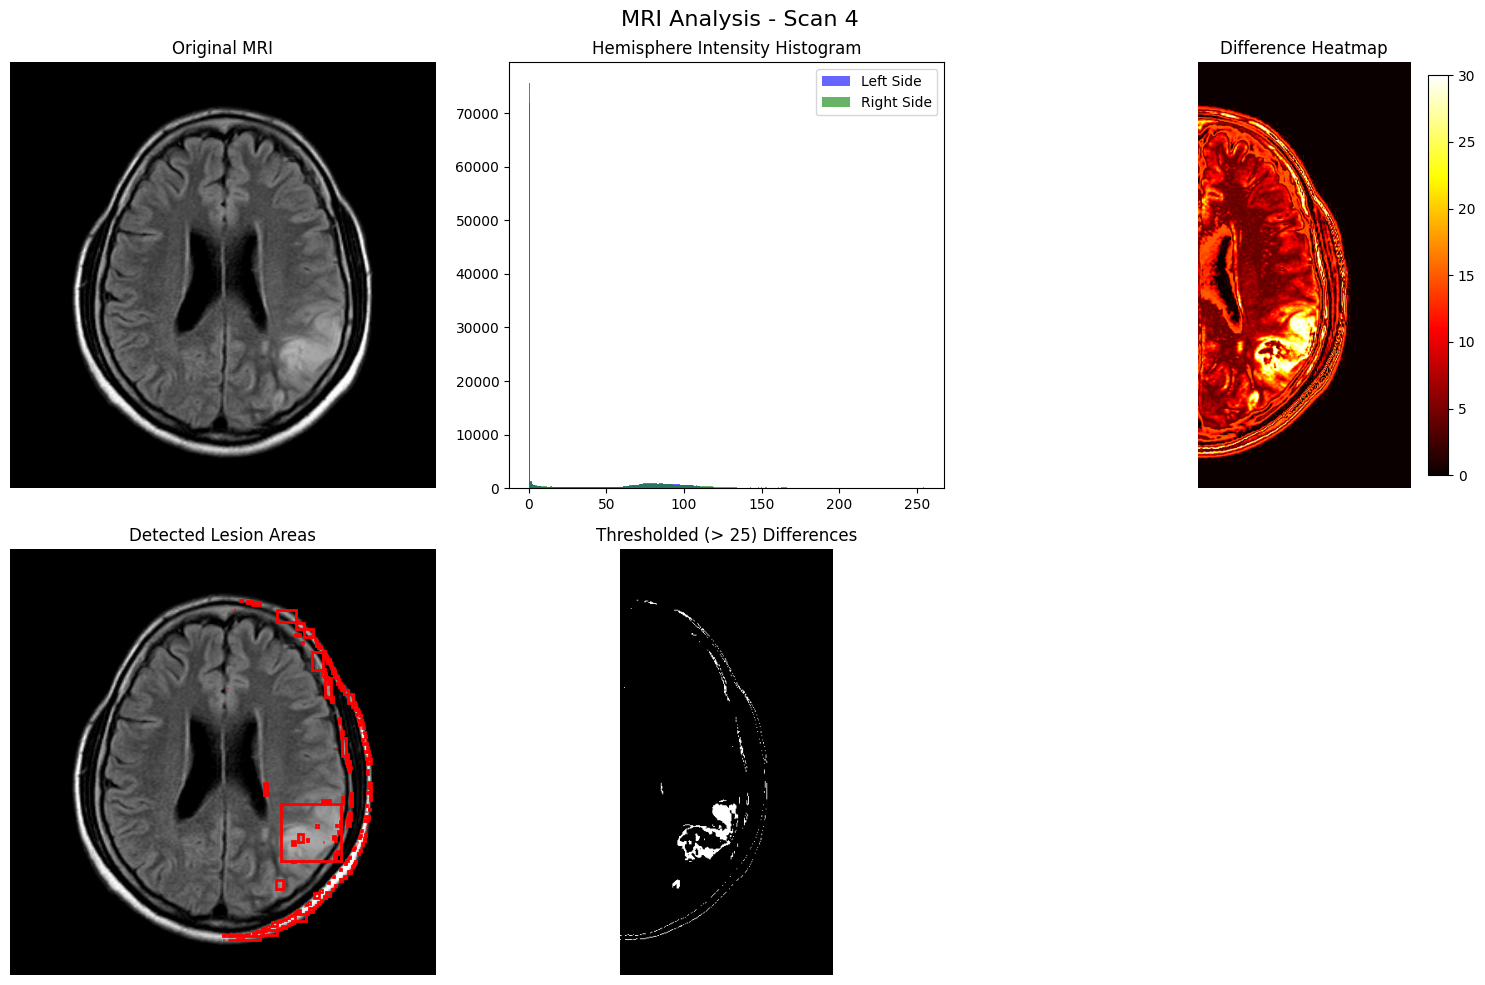

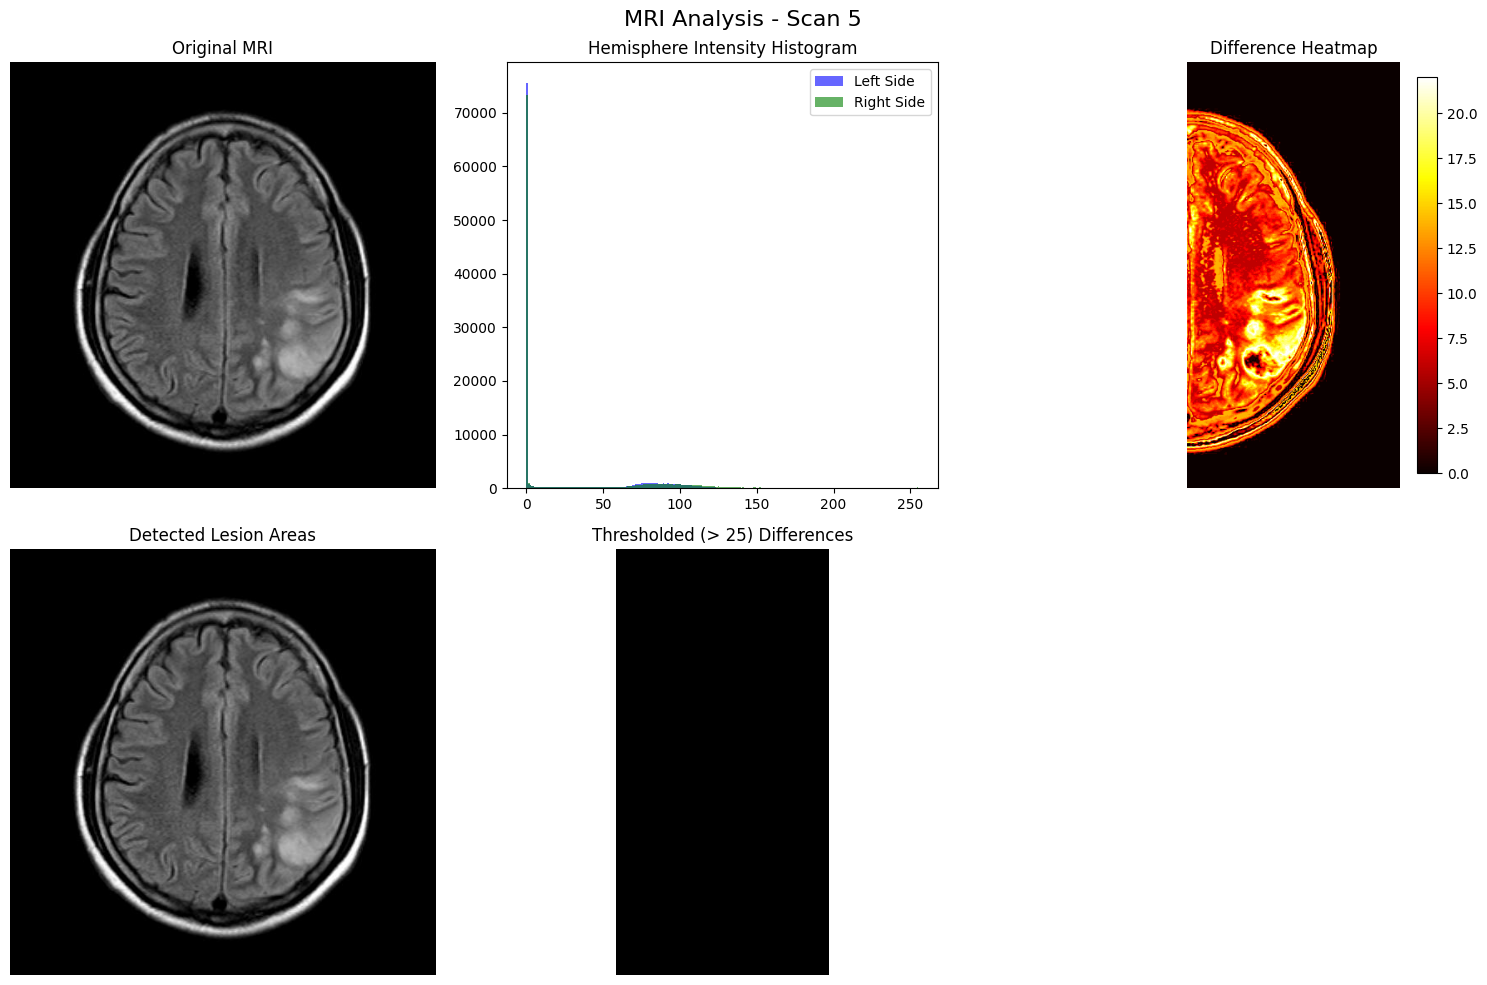

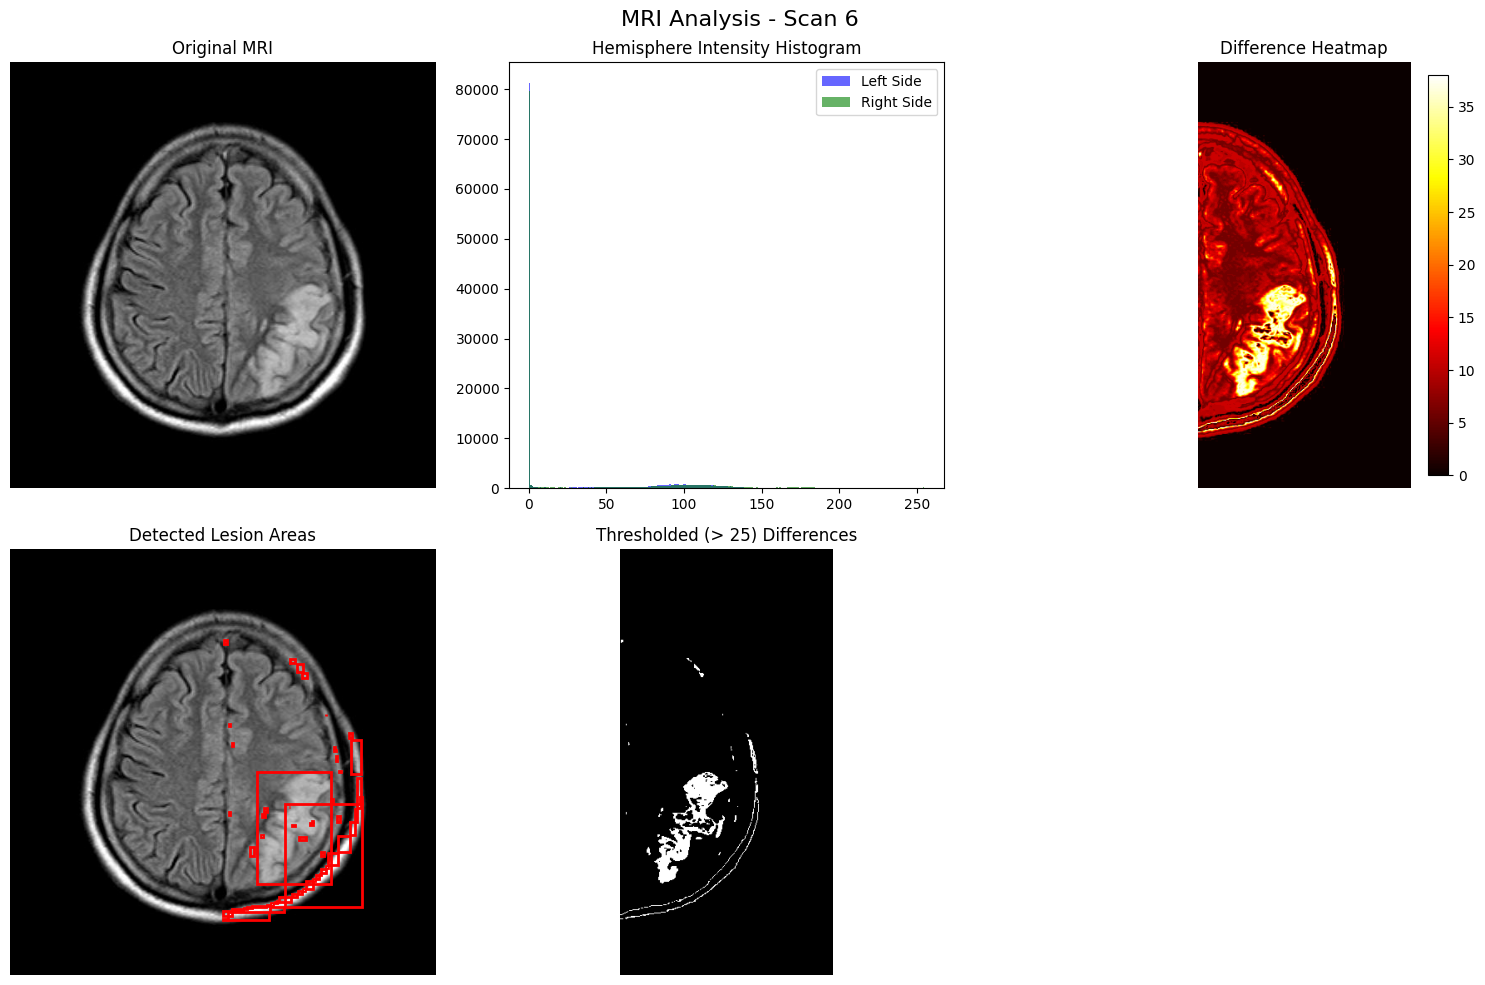

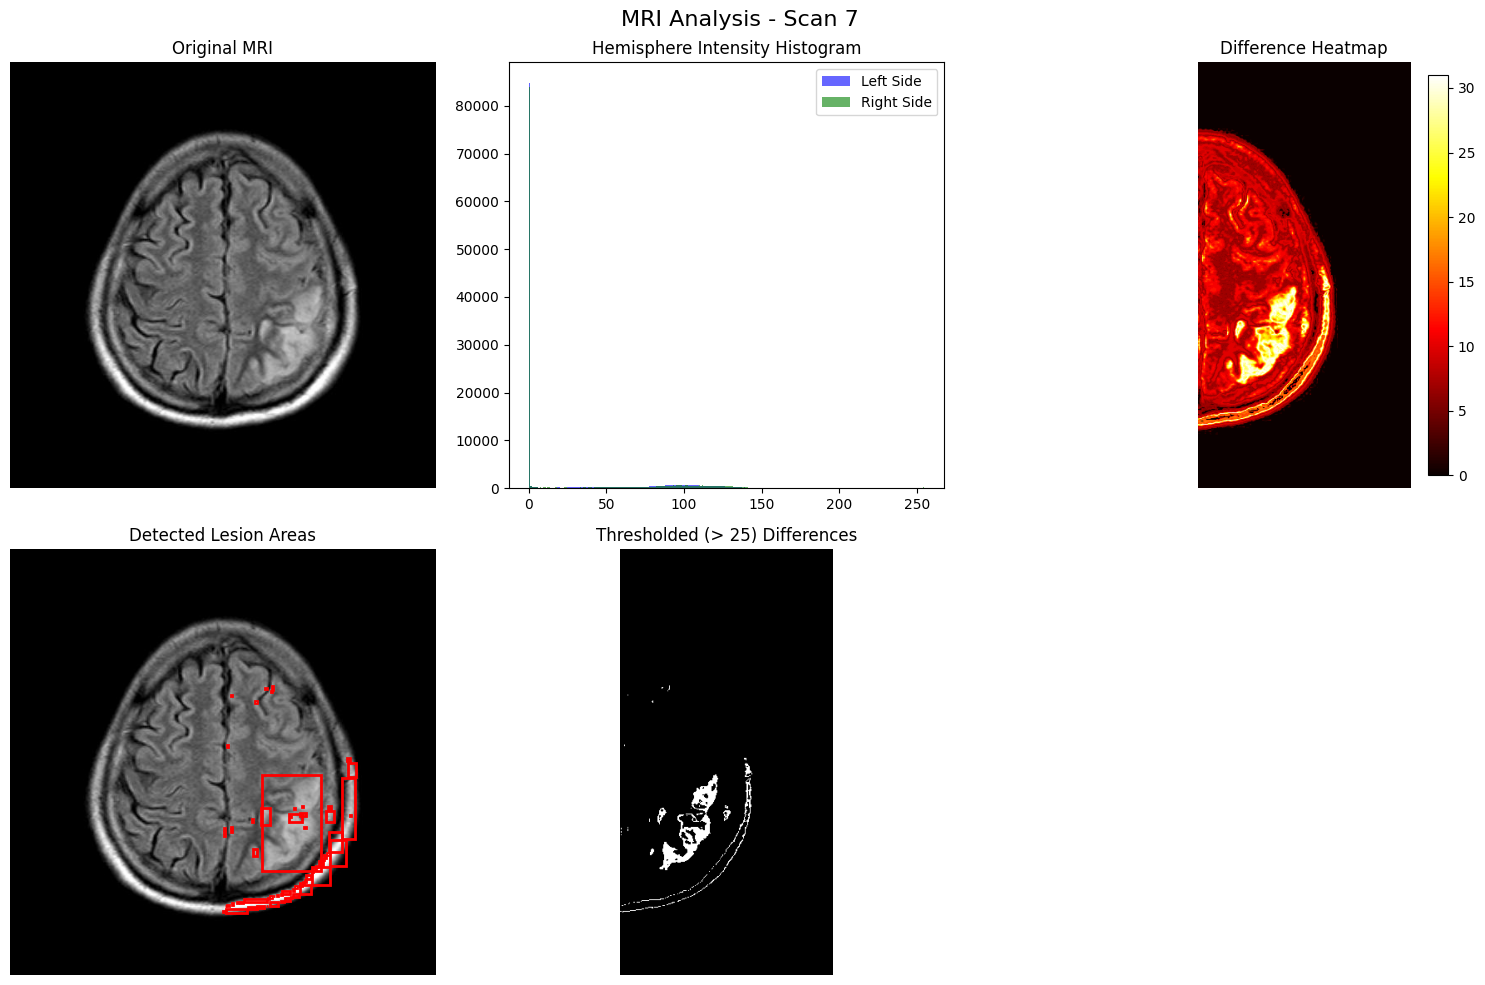

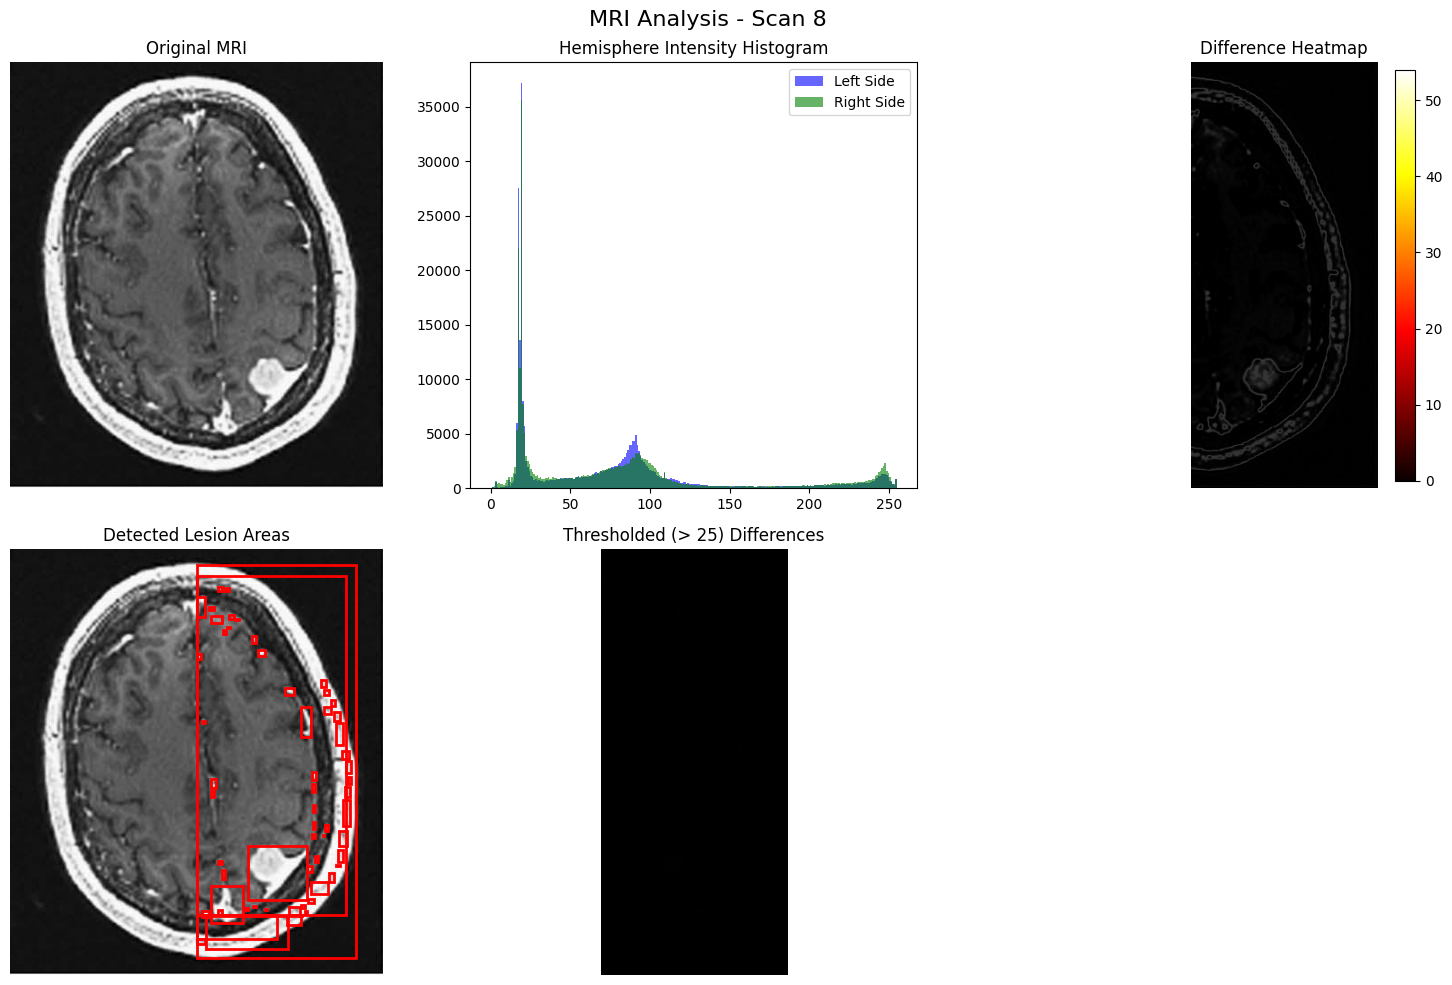

In [27]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops

# Read MRI images
mri_scans = [imageio.imread(f'{idx}.jpeg') for idx in range(1, 9)]

# Split into hemispheres
left_hemispheres = [img[:, :img.shape[1] // 2] for img in mri_scans]
right_hemispheres = [img[:, img.shape[1] // 2:] for img in mri_scans]

def perform_histogram_matching(source_img, reference_img):
    original_shape = source_img.shape
    src_flat = source_img.ravel()
    ref_flat = reference_img.ravel()

    src_values, src_bins, src_counts = np.unique(src_flat, return_inverse=True, return_counts=True)
    ref_values, ref_counts = np.unique(ref_flat, return_counts=True)

    src_cdf = np.cumsum(src_counts).astype(np.float64) / src_counts.sum()
    ref_cdf = np.cumsum(ref_counts).astype(np.float64) / ref_counts.sum()

    interp_values = np.interp(src_cdf, ref_cdf, ref_values)
    matched_img = interp_values[src_bins].reshape(original_shape).astype(np.uint8)

    return matched_img

def locate_lesions(difference_map, thresh=25):
    # Threshold difference image
    binary_map = difference_map > thresh
    # Label connected components
    labeled_img = label(binary_map)
    props = regionprops(labeled_img)
    return props

# Analyze each MRI scan
for idx in range(8):
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle(f'MRI Analysis - Scan {idx + 1}', fontsize=16)

    # Show the original scan
    plt.subplot(2, 3, 1)
    plt.imshow(mri_scans[idx], cmap='gray')
    plt.title('Original MRI')
    plt.axis('off')

    # Plot intensity histograms of each hemisphere
    plt.subplot(2, 3, 2)
    plt.hist(left_hemispheres[idx].ravel(), bins=256, color='blue', alpha=0.6, label='Left Side')
    plt.hist(right_hemispheres[idx].ravel(), bins=256, color='green', alpha=0.6, label='Right Side')
    plt.title('Hemisphere Intensity Histogram')
    plt.legend()

    # Match histograms and compute pixel-wise difference
    right_matched = perform_histogram_matching(right_hemispheres[idx], left_hemispheres[idx])
    pixel_diff = np.abs(right_matched.astype(np.int16) - right_hemispheres[idx].astype(np.int16)).astype(np.uint8)

    # Heatmap of differences
    plt.subplot(2, 3, 3)
    heatmap = plt.imshow(pixel_diff, cmap='hot')
    plt.title('Difference Heatmap')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.axis('off')

    # Identify and draw bounding boxes for lesions
    detected_lesions = locate_lesions(pixel_diff)

    plt.subplot(2, 3, 4)
    plt.imshow(mri_scans[idx], cmap='gray')
    for lesion in detected_lesions:
        try:
            # Get bounding box coordinates
            box = lesion.bbox
            if len(box) == 6:
                minr, minc, _, maxr, maxc, _ = box
            elif len(box) == 4:
                minr, minc, maxr, maxc = box
            else:
                continue

            # Adjust for right hemisphere position
            offset = mri_scans[idx].shape[1] // 2
            minc += offset
            maxc += offset
            width = maxc - minc
            height = maxr - minr
            lesion_rect = Rectangle((minc, minr), width, height,
                                    fill=False, edgecolor='red', linewidth=2)
            plt.gca().add_patch(lesion_rect)
        except Exception as err:
            print(f"Error processing lesion in scan {idx + 1}: {str(err)}")
            continue

    plt.title('Detected Lesion Areas')
    plt.axis('off')

    # Show binary mask after thresholding
    plt.subplot(2, 3, 5)
    bin_threshold = 25
    lesion_mask = pixel_diff > bin_threshold
    plt.imshow(lesion_mask.astype(np.uint8), cmap='gray')
    plt.title(f'Thresholded (> {bin_threshold}) Differences')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
